# Laboratorio 5 - Deep Learning
Andres de la Roca
Jun Woo Lee


In [1]:
import tensorflow as tf

import glob # Para leer archivos
import imageio # Para leer imagenes
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from keras import layers
import time

from IPython import display # Para mostrar imagenes

In [2]:
# Preparacion de dataset
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32') # Se agrega una dimension
train_images = (train_images - 127.5) / 127.5 # Normalizacion de las imagenes al rango [-1, 1]

BUFFER_SIZE = 60000 # Tamaño del buffer
BATCH_SIZE = 256 # Tamaño del batch

# Se crea el dataset
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Creacion de modelos
### Generador 

In [3]:
def generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

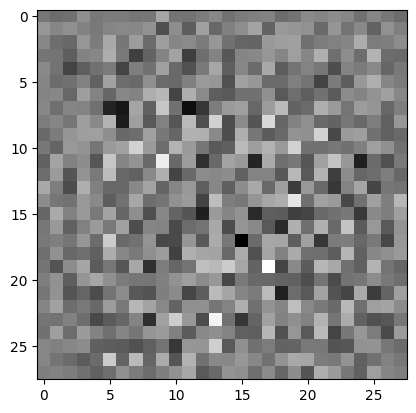

In [4]:
# Prueba de generacion de imagen
generator = generator_model()
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

### Discriminador

In [5]:
def discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [6]:
discriminator = discriminator_model()
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[-0.00076671]], shape=(1, 1), dtype=float32)


### Perdida y optimizadores

In [7]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True) # Funcion de perdida

In [8]:
def generator_loss(fake_out): # Funcion de perdida del generador
    return cross_entropy(tf.ones_like(fake_out), fake_out)

def discriminator_loss(real_out, fake_out): # Funcion de perdida del discriminador
    real_loss = cross_entropy(tf.ones_like(real_out), real_out)
    fake_loss = cross_entropy(tf.zeros_like(fake_out), fake_out)
    total_loss = real_loss + fake_loss
    return total_loss

In [9]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4) # Optimizador del generador
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4) # Optimizador del discriminador

In [10]:
# Maybe save checkpoints

### Entrenamiento

In [11]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim]) # Semilla para generar imagenes

In [12]:
@tf.function
def train_step(imagenes):
    noise = tf.random.normal([BATCH_SIZE, noise_dim]) # Se genera ruido

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True) # Se genera imagen
        real_output = discriminator(imagenes, training=True) # Se evalua imagen real
        fake_output = discriminator(generated_images, training=True) # Se evalua imagen falsa

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_gen = gen_tape.gradient(gen_loss, generator.trainable_variables) # Se calculan gradientes del generador
    gradients_disc = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_gen, generator.trainable_variables)) # Se aplica optimizacion
    discriminator_optimizer.apply_gradients(zip(gradients_disc, discriminator.trainable_variables))

In [13]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False) # Se genera imagen

    fig = plt.figure(figsize=(4,4)) # Se crea figura

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch)) # Se guarda imagen
    plt.show()

In [14]:
def train(dataset, epochs):
    for epoch in range(epochs):
        
        for image_batch in dataset:
            train_step(image_batch)
        
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)

    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

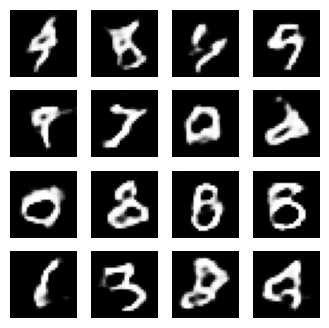

In [15]:
train(train_dataset, EPOCHS)

### Mostrando resultados

In [16]:
def display_img(epoch_no):
    return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

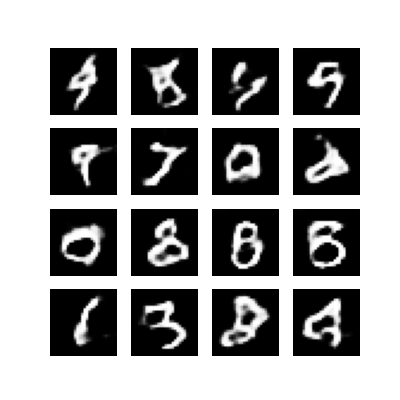

In [17]:
display_img(EPOCHS)

In [18]:
anim_file = 'GAN.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('image*.png') # Se obtienen imagenes
    filenames = sorted(filenames) # Se ordenan
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

C:\Users\Andrès DLR\AppData\Local\Temp\ipykernel_13344\977141024.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
C:\Users\Andrès DLR\AppData\Local\Temp\ipykernel_13344\977141024.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
